In [1]:
import torch
import torch_geometric.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
device = 'cpu'

# <span style="color:darkblue">Uncertainty Matching Graph Neural Networks</span>

### <span style="color:black">Demo</span>



`Jay Thiagarajan`, `Udayshankar Shanthamallu`      

# <span style="color:darkblue">Graph Neural Networks are Powerful at Modeling Structured Data</span>

+ Let us consider a node classification problem!

In [4]:
from greatx.datasets import GraphDataset
from greatx.utils import split_nodes
dname = 'citeseer'
root = 'data'
dataset = GraphDataset(root=root, name=dname,
                       transform=T.LargestConnectedComponents())
data = dataset[0]
splits = split_nodes(data.y, random_state=15)
num_features = data.x.size(-1)
num_classes = data.y.max().item() + 1
print(data)

Data(x=[2110, 3703], edge_index=[2, 7336], y=[2110])


# <span style="color:darkblue">Train a GCN Model for Node Classification</span>

In [5]:
from greatx.nn.models import GCN
from greatx.training.trainer import Trainer
surr = Trainer(GCN(num_features, num_classes, hids = [32],dropout=0.5),lr = 0.005,device=device)
surr.fit(data = data, mask=(splits.train_nodes, splits.val_nodes), epochs = 150)
logs = surr.evaluate(data, splits.test_nodes,verbose=0)
print(f"Done training GCN on Clean Graph! (Acc = {logs.acc})")

Training...
150/150 [==============================] - Total: 4.39s - 29ms/step- loss: 0.0229 - acc: 1 - val_loss: 1.19 - val_acc: 0.735
Done training GCN on Clean Graph! (Acc = 0.7055687308311462)


+ This model can be used as a surrogate for training targeted/untargeted adversarial attacks

# <span style="color:darkblue">What Happens to the GCN the Graph is Poisoned?</span>

In [6]:
from greatx.attack.untargeted import DICEAttack
attacker = DICEAttack(data, device=device)
attacker.reset()
noise_level = 0.9
attacker.attack(noise_level)

Peturbing graph...: 0it [00:00, ?it/s]

DICEAttack(device=cpu, seed=None,)

In [7]:
trainer_basic = Trainer(GCN(num_features, num_classes, hids = [32],dropout=0.5),lr = 0.005, device=device)
trainer_basic.fit(data = attacker.data(), mask=(splits.train_nodes, splits.val_nodes), epochs = 150,verbose=1)
logs = trainer_basic.evaluate(attacker.data(), splits.test_nodes,verbose=0)
print(f'Done training Vanilla GCN on Poisoned Graph (Acc = {logs.acc})')
acc_basic = logs.acc

Training...
150/150 [==============================] - Total: 4.39s - 29ms/step- loss: 0.0322 - acc: 1 - val_loss: 1.91 - val_acc: 0.469
Done training Vanilla GCN on Poisoned Graph (Acc = 0.44194313883781433)


+ The test performance drops by a signficant margin

# <span style="color:darkblue">UM-GNN: Leveraging Model Uncertainties for Reliable Training</span>

<img style="display: block; margin-left: auto; margin-right: auto; margin-bottom: auto; width: 65%;" src="files/umgnn.png" alt="UM-GNN">

# <span style="color:darkblue">Train a UM-GCN for the Poisoned Graph</span>

In [8]:
from greatx.nn.models import GCN
from modeldefs import FCN
from greatx.training.trainer_um import TrainerUM 
Gmodel = GCN(num_features, num_classes, hids = [32],dropout=0.8)
Hmodel = FCN(in_feats=num_features, hidden_neurons=[32], out_feats=num_classes)
trainer_umgnn = TrainerUM(Gmodel, Hmodel, lr = 0.005)
trainer_umgnn.fit(data = attacker.data(), mask=(splits.train_nodes, splits.val_nodes, splits.test_nodes), epochs = 200)
logs = trainer_umgnn.evaluate(attacker.data(), splits.test_nodes, mode = 'G')
acc_g = logs.acc
logs = trainer_umgnn.evaluate(attacker.data(), splits.test_nodes, mode = 'H')
acc_h = logs.acc
logs.pop('loss'); logs.pop('acc')
logs.update({'acc (GNN)': acc_basic, 'acc (UMGNN-G)': acc_g, 'acc (UMGNN-H)': acc_h})
print(logs)

Training...
200/200 [==============================] - Total: 44.23s - 221ms/step- loss: 0.0549 - acc: 0.493 - Hval_loss: 1.13 - Hval_acc: 0.629 - Gval_loss: 2.12 - Gval_acc: 0.44
Evaluating...
1/1 [==============================] - Total: 10.80ms - 10ms/step- loss: 2.12 - acc: 0.44
Evaluating...
1/1 [==============================] - Total: 11.37ms - 11ms/step- loss: 1.13 - acc: 0.629
╒═══════════════╤═══════════╕
│ Names         │   Objects │
╞═══════════════╪═══════════╡
│ acc (GNN)     │  0.441943 │
├───────────────┼───────────┤
│ acc (UMGNN-G) │  0.440166 │
├───────────────┼───────────┤
│ acc (UMGNN-H) │  0.628555 │
╘═══════════════╧═══════════╛


# <span style="color:darkblue">Let us Compare the Convergence of G and H Models</span> 

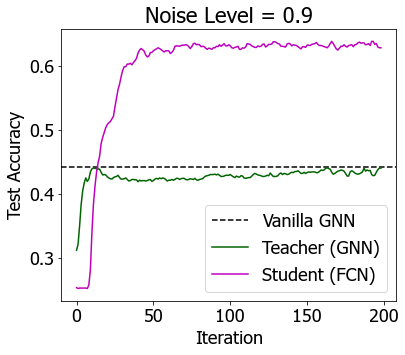

In [9]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Tahoma',
        'size'   : 18}
matplotlib.rc('font', **font)
Hval_acc = trainer_umgnn.callbacks._history.history.Hval_acc
Gval_acc = trainer_umgnn.callbacks._history.history.Gval_acc
plt.figure(figsize=(6,5))
plt.axhline(acc_basic , linestyle ='--', color='k', linewidth='1.5',label='Vanilla GNN')
plt.plot(Gval_acc[1:] , linestyle ='-', color='darkgreen', linewidth='1.5',label='Teacher (GNN)')
plt.plot(Hval_acc[1:] , linestyle ='-', color='m', linewidth='1.5',label='Student (FCN)')
plt.xlabel('Iteration'); plt.ylabel('Test Accuracy')
plt.title(f'Noise Level = {noise_level}')
plt.legend(); plt.show()

# <span style="color:darkblue">Now, Let us Try a More Sophisticated Attack</span> # 

In [10]:
from greatx.attack.untargeted import MinmaxAttack, PGDAttack

attack_type = 'MinmaxAttack'

if attack_type == 'MinmaxAttack':
    attacker = MinmaxAttack(data)
elif attack_type == 'PGDAttack':
    attacker = PGDAttack(data)

attacker.setup_surrogate(surr.model,
                         labeled_nodes=splits.train_nodes)
level = 0.4
    
attacker.reset()
attacker.attack(level)

Min-MAX training...:   0%|          | 0/100 [00:00<?, ?it/s]

Bernoulli sampling...:   0%|          | 0/20 [00:00<?, ?it/s]

MinmaxAttack(
  device=cpu, seed=None,
  (surrogate): GCN(
    (conv): Sequential(
      (0): GCNConv(3703, 32)
      (1): ReLU()
      (2): Dropout(p=0.5, inplace=False)
      (3): GCNConv(32, 6)
    )
  )
)

# <span style="color:darkblue">Even at Reasonable Noise Levels, the Performance Suffers</span>  

In [11]:
trainer_basic = Trainer(GCN(num_features, num_classes, hids = [32],dropout=0.5),lr = 0.0005)
trainer_basic.fit(data = attacker.data(), mask=(splits.train_nodes, splits.val_nodes), epochs = 150,verbose=1)
logs = trainer_basic.evaluate(attacker.data(), splits.test_nodes,verbose=0)
print(f'Done training Vanilla GCN on Poisoned Graph (Acc = {logs.acc})')
acc_basic = logs.acc

Training...
150/150 [==============================] - Total: 5.23s - 34ms/step- loss: 0.758 - acc: 0.858 - val_loss: 1.48 - val_acc: 0.45
Done training Vanilla GCN on Poisoned Graph (Acc = 0.4158767759799957)


# <span style="color:darkblue">And How Much Does UM-GNN Help?</span> 

In [12]:
from greatx.nn.models import GCN
from modeldefs import FCN
from greatx.training.trainer_um import TrainerUM 
Gmodel = GCN(num_features, num_classes, hids = [32],dropout=0.8)
Hmodel = FCN(in_feats=num_features, hidden_neurons=[32], out_feats=num_classes)
trainer_umgnn = TrainerUM(Gmodel, Hmodel, lr = 0.0005)
trainer_umgnn.fit(data = attacker.data(), mask=(splits.train_nodes, splits.val_nodes, splits.test_nodes), epochs = 200)
logs = trainer_umgnn.evaluate(attacker.data(), splits.test_nodes, mode = 'G')
acc_g = logs.acc
logs = trainer_umgnn.evaluate(attacker.data(), splits.test_nodes, mode = 'H')
acc_h = logs.acc
logs.pop('loss'); logs.pop('acc')
logs.update({'acc (GNN)': acc_basic, 'acc (UMGNN-G)': acc_g, 'acc (UMGNN-H)': acc_h})
print(logs)

Training...
200/200 [==============================] - Total: 47.32s - 236ms/step- loss: 1.3 - acc: 0.427 - Hval_loss: 1.31 - Hval_acc: 0.604 - Gval_loss: 1.64 - Gval_acc: 0.38
Evaluating...
1/1 [==============================] - Total: 12.47ms - 12ms/step- loss: 1.64 - acc: 0.38
Evaluating...
1/1 [==============================] - Total: 15.95ms - 15ms/step- loss: 1.31 - acc: 0.604
╒═══════════════╤═══════════╕
│ Names         │   Objects │
╞═══════════════╪═══════════╡
│ acc (GNN)     │  0.415877 │
├───────────────┼───────────┤
│ acc (UMGNN-G) │  0.380332 │
├───────────────┼───────────┤
│ acc (UMGNN-H) │  0.603673 │
╘═══════════════╧═══════════╛


# <span style="color:darkblue">The Convergence of G and H Models</span>

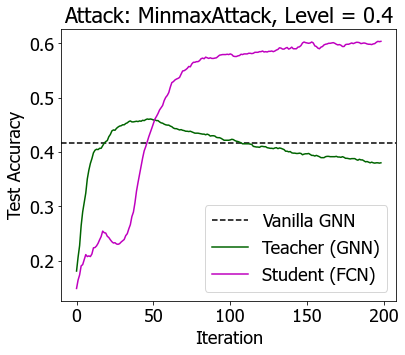

In [13]:
matplotlib.rc('font', **font)
Hval_acc = trainer_umgnn.callbacks._history.history.Hval_acc
Gval_acc = trainer_umgnn.callbacks._history.history.Gval_acc
plt.figure(figsize=(6,5))
plt.axhline(acc_basic , linestyle ='--', color='k', linewidth='1.5',label='Vanilla GNN')
plt.plot(Gval_acc[1:] , linestyle ='-', color='darkgreen', linewidth='1.5',label='Teacher (GNN)')
plt.plot(Hval_acc[1:] , linestyle ='-', color='m', linewidth='1.5',label='Student (FCN)')
plt.xlabel('Iteration'); plt.ylabel('Test Accuracy')
plt.title(f'Attack: {attacker.name}, Level = {level}')
plt.legend(); plt.show()

# <span style="color:darkblue">Resources</span>

+ Uncertainty-Matching Graph Neural Networks to Defend Against Poisoning Attacks, AAAI 2021. <a href="https://arxiv.org/abs/2009.14455"> `paper` </a>
+ Greatx library <a href="https://github.com/EdisonLeeeee/GreatX"> `Link` </a>